In [1]:
import numpy as np
import keras
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error as mse
from statistics import stdev 
from statistics import mean

from keras.callbacks import EarlyStopping
from keras import regularizers
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LSTM
from keras.layers import Dropout
from keras.models import Sequential
from keras.layers import Dense

np.random.seed (30)

Using TensorFlow backend.


In [2]:
    
def generate_next_data (current_time , x): # x is a 2d array. size of x: 1 row * (number of data points) col
    next_data = x[0][current_time] + ( ( 0.2 * x[0][current_time -25] )  /  (1+ (x[0][current_time -25])**10 )  ) -0.1* x[0][current_time]
    return next_data

def generate_input (t, x): # x: a 2D array. x stores Mackey Glass data
    l=[x[0][t-20],
      x[0][t-15],
      x[0][t-10],
      x[0][t-5],
      x[0][t]]
    return l

def generate_output (t, data_target_1531):
    return data_target_1531[0][t+5]


def generate_Mackey_Galss_Data( how_many_data_point):
    data_target_1531=np.zeros((1, how_many_data_point)) # 1 row * 1531 col
    data_target_1531[0][25]=1.5
    for i in range (25, 1530):
        data_target_1531[0][i+1] = generate_next_data (i, data_target_1531)
    # print( data_target_1531.shape)
    return data_target_1531


# add gaussian noise to my pure data
def add_noise (data_target_1531, noise_std_dev): 
    noise_mean=0
    noise = np.random.normal(noise_mean, noise_std_dev, data_target_1531.shape)  # np.random.normal(mu, sigma, 1000)
    data_target_1531_noise = data_target_1531 + noise
    return data_target_1531_noise

def generate_inputArray_outputArray (data_target_1531):
    inputData = []
    outputData = []
    for j in range(301, 1501):
        i =j+25
        inputData.append (generate_input (i, data_target_1531) )
        outputData.append (generate_output (i, data_target_1531) )

    inputData = np.array(inputData, dtype=float) # convert list to array
    outputData = np.array(outputData, dtype=float)

    return inputData, outputData


# split to train, validation, and test data
#split_1: split between train and val. 
#split_2: split between val and test. 
def split (inputData, outputData): 
    
    train_input,  val_input,  test_input  =  inputData[:split_1 , :], inputData[ split_1:split_2 , :], inputData[split_2:, :]
    train_output, val_output, test_output =  outputData[:split_1],    outputData[ split_1:split_2 ],    outputData[split_2:]

    return train_input, val_input, test_input, train_output, val_output, test_output

def generate_6_DataSet (data_target_1531 ): # standard deviation: choose std_1 or std_2 or std_3
  
    inputData, outputData = generate_inputArray_outputArray (data_target_1531 )
    train_in, val_in, test_in, train_out, val_out, test_out       = split (inputData, outputData)
    return train_in, val_in, test_in, train_out, val_out, test_out

##############################
def draw ( l, color):
    index_list= range( len (l))
    plt.scatter (index_list, l, c=color)
    plt.show()

    
def draw_2_scatters ( l1, color1, l2, color2):
    index_list= range( len (l1))
    p1=plt.scatter (index_list, l1, c=color1, s=10) # s: marker size
    p2=plt.scatter (index_list, l2, c=color2, s=10)
    
    plt.legend( (p1,p2), ('pure data', 'noised data'), scatterpoints=1, loc='lower left', ncol=1, fontsize=10)
    plt.show()
    
def draw_3_scatters ( l1, color1, l2, color2, l3, color3):
    index_list= range( len (l1))
    p1=plt.scatter (index_list, l1, c=color1, s=10) # s: marker size
    p2=plt.scatter (index_list, l2, c=color2, s=10)
    p3=plt.scatter (index_list, l3, c=color3, s=10)
    
    plt.legend( (p1,p2,p3), ('pure data', 'noised data', 'prediction'), scatterpoints=1, loc='lower left',  ncol=1, fontsize=10)
    plt.show()
    
def draw_1_line (title, xlabel, ylabel, ymin,ymax, l0, l1, color1, label1  ):
#     index_list= range( len (l1))
    fig = plt.figure() 
    ax = plt.subplot(111)
    ax.plot(l0, l1, c=color1, label= label1 )
    plt.title(title )
    ax.legend()
    plt.xlabel(xlabel ) 
    plt.ylabel(ylabel )
    ax.set_ylim([ymin,ymax])
    plt.savefig('D:/Sweden/p3/ANN/lab1/part2/'+ title + '.png', dpi=300)
    plt.show()
    
def draw_2_line ( title, xlabel, ylabel, l0, l1, color1, label1, l2, color2, label2 ):
    
    fig = plt.figure() 
    ax = plt.subplot(111)
    ax.plot(l0, l1, c=color1, label= label1 )
    ax.plot(l0, l2, c=color2, label= label2)
    plt.title(title)
    plt.xlabel(xlabel ) 
    plt.ylabel(ylabel ) 
    ax.legend()
    plt.show()
        
def draw_3_line (title, xlabel, ylabel, ymin,ymax, l0, l1, color1, label1, l2, color2, label2, l3, color3, label3 ):
#     index_list= range( len (l1))
    fig = plt.figure() 
    ax = plt.subplot(111)
    ax.plot(l0, l1, c=color1, label= label1 )
    ax.plot(l0, l2, c=color2, label= label2 )
    ax.plot(l0, l3, c=color3, label= label3 )
    plt.title(title )
    ax.legend()
    plt.xlabel(xlabel ) 
    plt.ylabel(ylabel )
    ax.set_ylim([ymin,ymax])
    plt.savefig('D:/Sweden/p3/ANN/lab1/part2/'+ title + '.png', dpi=300)
    plt.show()

In [4]:

data_target_1531 = generate_Mackey_Galss_Data(1531)

std_1=0.03
std_2=0.09
std_3=0.18


data_target_1531_noise1 = add_noise (data_target_1531, std_1 )
data_target_1531_noise2 = add_noise (data_target_1531, std_2 )
data_target_1531_noise3 = add_noise (data_target_1531, std_3 )

split_1 = 900
split_2 = 1000


train_in_pure,  val_in_pure,  test_in_pure,  train_out_pure,  val_out_pure,  test_out_pure = generate_6_DataSet (data_target_1531 )

train_in_noise1, val_in_noise1, test_in_noise1, train_out_noise1, val_out_noise1, test_out_noise1 = generate_6_DataSet (data_target_1531_noise1 )
train_in_noise2, val_in_noise2, test_in_noise2, train_out_noise2, val_out_noise2, test_out_noise2 = generate_6_DataSet (data_target_1531_noise2 )
train_in_noise3, val_in_noise3, test_in_noise3, train_out_noise3, val_out_noise3, test_out_noise3 = generate_6_DataSet (data_target_1531_noise3 )


# draw_2_line ( 'time', 'target', range( len (val_out_pure[:])) , 
#              val_out_pure[:], 'c', 'pure', 
#              val_out_noise1[:],'b', 'noise')

# draw_2_scatters (train_out_pure[:], 'c', train_out_noise1[:],'b')
# draw_2_scatters (train_out_pure[:], 'c', train_out_noise2[:],'b')
# draw_2_scatters (train_out_pure[:], 'c', train_out_noise3[:],'b')




In [5]:
def plot_loss(model_history):
    
    plt.plot (model_history.history['loss'])
    plt.show ()
    return 

def predict (kerasModel, test_data  ):
    prediction = kerasModel.predict(test_data)
    return prediction



# L1: Sum of the absolute weights.
# L2: Sum of the squared weights.
# L1L2: Sum of the absolute and the squared weights.
# kernel_regularizer: means weight regularizer  we only use this
# bias_regularizer
# activity_regularizer

def train_2_layer_NN (train_input, train_output, val_input, val_output, 
                      learning_rate, regu_strength, num_neurons_layer1): 
    dim_InputData =5
    num_neurons_output=1
    
    model = Sequential()  
    model.add(Dense( num_neurons_layer1, 
                     input_shape=(dim_InputData,),
                     activation='sigmoid',
                     kernel_regularizer=regularizers.l1(regu_strength),  # regularizer l2 norm  defalt 0.01
                   ) )  
    model.add(Dense(num_neurons_output))

    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate)  )

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)  # 
    
    history=model.fit(train_input, train_output, 
                      validation_data=(val_input, val_output), #validation_split=0.1, 
                      nb_epoch=100, 
                      batch_size=1, 
                      verbose=1,
                      callbacks = [es]
                     )

    return model, history



# # epoch_convergent = len (model_pure_history.history['val_loss'])
# def average(lst): 
#     return sum(lst) / len(lst) 


def regularization_validation (train_in_pure, train_out_pure, val_in_pure, val_out_pure, test_in_pure, test_out_pure, 
                               learning_rate, regu_strength_list, num_neurons_layer1):
    val_MSE_list= []
    test_MSE_list =[]
    train_MSE_list =[]
    print ("num_neurons_layer1: ", num_neurons_layer1)
    
    for i in range ( 0, len (regu_strength_list) ):
        model_pure, model_history = train_2_layer_NN(train_in_pure, train_out_pure, val_in_pure, val_out_pure, learning_rate, regu_strength_list[i], num_neurons_layer1)
        val_MSE = model_history.history['val_loss'][-1]
        val_MSE_list.append (val_MSE)

        train_MSE = model_history.history['loss'][-1]
        train_MSE_list.append (train_MSE)
        
        prediction = predict (model_pure, test_in_pure)
        MSE= mse (test_out_pure, prediction) 
        test_MSE_list.append (MSE)
        
    return val_MSE_list, test_MSE_list, train_MSE_list

In [6]:

num_neurons_layer1 = 3
learning_rate = 0.001
regu_strength_list = [ 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009, 0.001 ]
valMSE_of_regu, testMSE_of_regu, trainMSE_of_regu = regularization_validation (train_in_pure, train_out_pure, val_in_pure, val_out_pure, test_in_pure, test_out_pure, 
                                                                               learning_rate, regu_strength_list, num_neurons_layer1)

draw_3_line ( 'regularization strength','mean squared error', regu_strength_list ,
                 valMSE_of_regu,   'm', 'validation', 
                 testMSE_of_regu,  'b', 'test', 
                 trainMSE_of_regu, 'g',  'train' )


print (valMSE_of_regu)
print (testMSE_of_regu)
print (trainMSE_of_regu)

num_neurons_layer1:  3


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 894us/step - loss: 0.1361 - val_loss: 0.0593
Epoch 2/100
900/900 [==============================] - 1s 970us/step - loss: 0.0622 - val_loss: 0.0478
Epoch 3/100
900/900 [==============================] - 1s 872us/step - loss: 0.0525 - val_loss: 0.0425
Epoch 4/100
900/900 [==============================] - 1s 786us/step - loss: 0.0446 - val_loss: 0.0330
Epoch 5/100
900/900 [==============================] - 1s 814us/step - loss: 0.0377 - val_loss: 0.0276
Epoch 6/100
900/900 [==============================] - 1s 807us/step - loss: 0.0330 - val_loss: 0.0242
Epoch 7/100
900/900 [==============================] - 1s 848us/step - loss: 0.0300 - val_loss: 0.0233
Epoch 8/100
900/900 [==============================] - 1s 910us/step - loss: 0.0281 - val_loss: 0.0210
Epoch 9/100
900/900 [==============================] - 1s 895us/step - loss: 0.0267 - val_loss: 0.0199
Epoch 10/100
900/900 [=====

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 941us/step - loss: 0.0957 - val_loss: 0.0638
Epoch 2/100
900/900 [==============================] - 1s 913us/step - loss: 0.0694 - val_loss: 0.0492
Epoch 3/100
900/900 [==============================] - 1s 833us/step - loss: 0.0541 - val_loss: 0.0371
Epoch 4/100
900/900 [==============================] - 1s 975us/step - loss: 0.0421 - val_loss: 0.0288
Epoch 5/100
900/900 [==============================] - 1s 873us/step - loss: 0.0341 - val_loss: 0.0228
Epoch 6/100
900/900 [==============================] - 1s 842us/step - loss: 0.0291 - val_loss: 0.0220
Epoch 7/100
900/900 [==============================] - 1s 822us/step - loss: 0.0263 - val_loss: 0.0183
Epoch 8/100
900/900 [==============================] - 1s 864us/step - loss: 0.0246 - val_loss: 0.0179
Epoch 9/100
900/900 [==============================] - 1s 933us/step - loss: 0.0235 - val_loss: 0.0174
Epoch 10/100
900/900 [=====

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 870us/step - loss: 0.1167 - val_loss: 0.0779
Epoch 2/100
900/900 [==============================] - 1s 784us/step - loss: 0.0768 - val_loss: 0.0545
Epoch 3/100
900/900 [==============================] - 1s 786us/step - loss: 0.0622 - val_loss: 0.0443
Epoch 4/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0518 - val_loss: 0.0365
Epoch 5/100
900/900 [==============================] - 1s 839us/step - loss: 0.0438 - val_loss: 0.0320
Epoch 6/100
900/900 [==============================] - 1s 853us/step - loss: 0.0383 - val_loss: 0.0278
Epoch 7/100
900/900 [==============================] - 1s 932us/step - loss: 0.0345 - val_loss: 0.0254
Epoch 8/100
900/900 [==============================] - 1s 927us/step - loss: 0.0318 - val_loss: 0.0238
Epoch 9/100
900/900 [==============================] - 1s 933us/step - loss: 0.0300 - val_loss: 0.0232
Epoch 10/100
900/900 [=======

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 890us/step - loss: 0.0836 - val_loss: 0.0495
Epoch 2/100
900/900 [==============================] - 1s 796us/step - loss: 0.0535 - val_loss: 0.0402
Epoch 3/100
900/900 [==============================] - 1s 792us/step - loss: 0.0417 - val_loss: 0.0295
Epoch 4/100
900/900 [==============================] - 1s 784us/step - loss: 0.0333 - val_loss: 0.0232
Epoch 5/100
900/900 [==============================] - 1s 923us/step - loss: 0.0283 - val_loss: 0.0211
Epoch 6/100
900/900 [==============================] - 1s 930us/step - loss: 0.0258 - val_loss: 0.0212
Epoch 00006: early stopping


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 832us/step - loss: 0.1030 - val_loss: 0.0571
Epoch 2/100
900/900 [==============================] - 1s 839us/step - loss: 0.0658 - val_loss: 0.0432
Epoch 3/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0525 - val_loss: 0.0350
Epoch 4/100
900/900 [==============================] - 1s 761us/step - loss: 0.0426 - val_loss: 0.0277
Epoch 5/100
900/900 [==============================] - 1s 758us/step - loss: 0.0355 - val_loss: 0.0244
Epoch 6/100
900/900 [==============================] - 1s 827us/step - loss: 0.0314 - val_loss: 0.0233
Epoch 7/100
900/900 [==============================] - 1s 992us/step - loss: 0.0289 - val_loss: 0.0206
Epoch 8/100
900/900 [==============================] - 1s 827us/step - loss: 0.0272 - val_loss: 0.0203
Epoch 9/100
900/900 [==============================] - 1s 830us/step - loss: 0.0258 - val_loss: 0.0194
Epoch 10/100
900/900 [=======

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 836us/step - loss: 0.0661 - val_loss: 0.0530
Epoch 2/100
900/900 [==============================] - 1s 760us/step - loss: 0.0482 - val_loss: 0.0360
Epoch 3/100
900/900 [==============================] - 1s 772us/step - loss: 0.0369 - val_loss: 0.0307
Epoch 4/100
900/900 [==============================] - 1s 769us/step - loss: 0.0311 - val_loss: 0.0246
Epoch 5/100
900/900 [==============================] - 1s 761us/step - loss: 0.0284 - val_loss: 0.0226
Epoch 6/100
900/900 [==============================] - 1s 773us/step - loss: 0.0268 - val_loss: 0.0217
Epoch 7/100
900/900 [==============================] - 1s 790us/step - loss: 0.0257 - val_loss: 0.0214
Epoch 8/100
900/900 [==============================] - 1s 763us/step - loss: 0.0249 - val_loss: 0.0205
Epoch 9/100
900/900 [==============================] - 1s 764us/step - loss: 0.0243 - val_loss: 0.0199
Epoch 10/100
900/900 [=====

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 859us/step - loss: 0.7640 - val_loss: 0.2193
Epoch 2/100
900/900 [==============================] - 1s 771us/step - loss: 0.1198 - val_loss: 0.0752
Epoch 3/100
900/900 [==============================] - 1s 893us/step - loss: 0.0837 - val_loss: 0.0647
Epoch 4/100
900/900 [==============================] - 1s 779us/step - loss: 0.0793 - val_loss: 0.0612
Epoch 5/100
900/900 [==============================] - 1s 901us/step - loss: 0.0715 - val_loss: 0.0525
Epoch 6/100
900/900 [==============================] - 1s 902us/step - loss: 0.0584 - val_loss: 0.0410
Epoch 7/100
900/900 [==============================] - 1s 904us/step - loss: 0.0440 - val_loss: 0.0300
Epoch 8/100
900/900 [==============================] - 1s 999us/step - loss: 0.0345 - val_loss: 0.0235
Epoch 9/100
900/900 [==============================] - 1s 992us/step - loss: 0.0293 - val_loss: 0.0208
Epoch 10/100
900/900 [=====

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 838us/step - loss: 0.4870 - val_loss: 0.0762
Epoch 2/100
900/900 [==============================] - 1s 897us/step - loss: 0.0846 - val_loss: 0.0650
Epoch 3/100
900/900 [==============================] - 1s 959us/step - loss: 0.0715 - val_loss: 0.0523
Epoch 4/100
900/900 [==============================] - 1s 811us/step - loss: 0.0590 - val_loss: 0.0430
Epoch 5/100
900/900 [==============================] - 1s 852us/step - loss: 0.0479 - val_loss: 0.0336
Epoch 6/100
900/900 [==============================] - 1s 864us/step - loss: 0.0393 - val_loss: 0.0277
Epoch 7/100
900/900 [==============================] - 1s 825us/step - loss: 0.0336 - val_loss: 0.0243
Epoch 8/100
900/900 [==============================] - 1s 870us/step - loss: 0.0303 - val_loss: 0.0226
Epoch 9/100
900/900 [==============================] - 1s 815us/step - loss: 0.0284 - val_loss: 0.0217
Epoch 10/100
900/900 [=====

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 954us/step - loss: 0.2856 - val_loss: 0.0722
Epoch 2/100
900/900 [==============================] - 1s 846us/step - loss: 0.0846 - val_loss: 0.0698
Epoch 3/100
900/900 [==============================] - 1s 849us/step - loss: 0.0794 - val_loss: 0.0660
Epoch 4/100
900/900 [==============================] - 1s 901us/step - loss: 0.0708 - val_loss: 0.0540
Epoch 5/100
900/900 [==============================] - 1s 830us/step - loss: 0.0579 - val_loss: 0.0418
Epoch 6/100
900/900 [==============================] - 1s 832us/step - loss: 0.0446 - val_loss: 0.0315
Epoch 7/100
900/900 [==============================] - 1s 902us/step - loss: 0.0350 - val_loss: 0.0263
Epoch 8/100
900/900 [==============================] - 1s 828us/step - loss: 0.0313 - val_loss: 0.0243
Epoch 9/100
900/900 [==============================] - 1s 806us/step - loss: 0.0295 - val_loss: 0.0239
Epoch 10/100
900/900 [=====

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 859us/step - loss: 0.9326 - val_loss: 0.2702
Epoch 2/100
900/900 [==============================] - 1s 751us/step - loss: 0.1402 - val_loss: 0.0869
Epoch 3/100
900/900 [==============================] - 1s 763us/step - loss: 0.0870 - val_loss: 0.0716
Epoch 4/100
900/900 [==============================] - 1s 752us/step - loss: 0.0835 - val_loss: 0.0697
Epoch 5/100
900/900 [==============================] - 1s 814us/step - loss: 0.0797 - val_loss: 0.0659
Epoch 6/100
900/900 [==============================] - 1s 982us/step - loss: 0.0713 - val_loss: 0.0567
Epoch 7/100
900/900 [==============================] - 1s 836us/step - loss: 0.0591 - val_loss: 0.0454
Epoch 8/100
900/900 [==============================] - 1s 872us/step - loss: 0.0464 - val_loss: 0.0341
Epoch 9/100
900/900 [==============================] - 1s 972us/step - loss: 0.0356 - val_loss: 0.0251
Epoch 10/100
900/900 [=====

TypeError: draw_3_line() missing 3 required positional arguments: 'l3', 'color3', and 'label3'

In [60]:

def num_neurons_validation_2lay (train_in_pure, train_out_pure, val_in_pure, val_out_pure, test_in_pure, test_out_pure,
                            learning_rate, regu_strength, num_neurons_layer1_list):
    val_MSE_list= []
    test_mse_list =[]
    train_MSE_list =[]
    time_2lay =[]
    
    for i in range (0, len (num_neurons_layer1_list) ):
        start_time = time.time()

        model_pure, model_history = train_2_layer_NN(train_in_pure, train_out_pure, val_in_pure, val_out_pure, 
                                                     learning_rate, regu_strength, num_neurons_layer1_list[i])
        end_time = time.time()
        time_spent= end_time - start_time    
        time_2lay.append(time_spent)
        
        val_MSE = model_history.history['val_loss'][-1]
        val_MSE_list.append (val_MSE)
        
        train_MSE = model_history.history['loss'][-1]
        train_MSE_list.append (train_MSE)  
        
        prediction = predict (model_pure, test_in_pure)
        MSE= mse (test_out_pure, prediction) 
        test_mse_list.append (MSE)
        
    return val_MSE_list, test_mse_list , train_MSE_list, time_2lay


regu_strength = 0.0001
num_neurons_layer1 = [1,2,3,4,5,6,7,8]
learning_rate = 0.001
valMSE_of_NumNeurons_2lay, testMSE_of_NumNeurons_2lay, trainMSE_of_NumNeurons_2lay, time_2lay = num_neurons_validation_2lay (train_in_pure, train_out_pure, val_in_pure, val_out_pure, test_in_pure, test_out_pure,
                                                                                                         learning_rate, regu_strength, num_neurons_layer1)






c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 1ms/step - loss: 0.1281 - val_loss: 0.0910
Epoch 2/100
900/900 [==============================] - 1s 871us/step - loss: 0.0888 - val_loss: 0.0728
Epoch 3/100
900/900 [==============================] - 1s 857us/step - loss: 0.0819 - val_loss: 0.0669
Epoch 4/100
900/900 [==============================] - 1s 897us/step - loss: 0.0781 - val_loss: 0.0628
Epoch 5/100
900/900 [==============================] - 1s 836us/step - loss: 0.0738 - val_loss: 0.0593
Epoch 6/100
900/900 [==============================] - 1s 860us/step - loss: 0.0699 - val_loss: 0.0557
Epoch 7/100
900/900 [==============================] - 1s 827us/step - loss: 0.0666 - val_loss: 0.0526
Epoch 8/100
900/900 [==============================] - 1s 843us/step - loss: 0.0632 - val_loss: 0.0495
Epoch 9/100
900/900 [==============================] - 1s 807us/step - loss: 0.0599 - val_loss: 0.0465
Epoch 10/100
900/900 [=======

KeyboardInterrupt: 

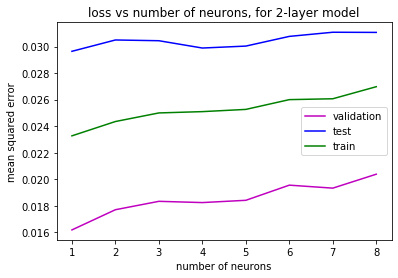

[0.016192265853751452, 0.01771292063756846, 0.01834492899244651, 0.01825078488793224, 0.018421834993641823, 0.019562502668704837, 0.01933752158423886, 0.020387741911690682]
[0.02963927366530003, 0.03049275436675431, 0.030436720656846487, 0.029886222552687077, 0.030032740617752608, 0.030762715166235452, 0.031075029053270073, 0.031062940528894373]
[0.023274940468577875, 0.02435315988996687, 0.02499985119133877, 0.025098482283194445, 0.02526562629862585, 0.02600161549764582, 0.026066735639599048, 0.026974885399298123]


In [51]:
draw_3_line ( 'loss vs number of neurons, for 2-layer model','number of neurons','mean squared error', num_neurons_layer1 ,
                 valMSE_of_NumNeurons_2lay,   'm', 'validation', 
                 testMSE_of_NumNeurons_2lay,  'b', 'test', 
                 trainMSE_of_NumNeurons_2lay, 'g',  'train' )
print (valMSE_of_NumNeurons_2lay)
print (testMSE_of_NumNeurons_2lay)
print (trainMSE_of_NumNeurons_2lay)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 989us/step - loss: 0.2482 - val_loss: 0.0590
Epoch 2/100
900/900 [==============================] - 1s 789us/step - loss: 0.0687 - val_loss: 0.0470
Epoch 3/100
900/900 [==============================] - 1s 810us/step - loss: 0.0550 - val_loss: 0.0369
Epoch 4/100
900/900 [==============================] - 1s 794us/step - loss: 0.0453 - val_loss: 0.0307
Epoch 5/100
900/900 [==============================] - 1s 772us/step - loss: 0.0384 - val_loss: 0.0276
Epoch 6/100
900/900 [==============================] - 1s 781us/step - loss: 0.0351 - val_loss: 0.0244
Epoch 7/100
900/900 [==============================] - 1s 790us/step - loss: 0.0323 - val_loss: 0.0228
Epoch 8/100
900/900 [==============================] - 1s 790us/step - loss: 0.0304 - val_loss: 0.0214
Epoch 9/100
900/900 [==============================] - 1s 934us/step - loss: 0.0288 - val_loss: 0.0204
Epoch 10/100
900/900 [=====

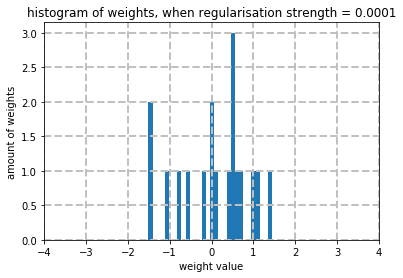

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 871us/step - loss: 0.2149 - val_loss: 0.0587
Epoch 2/100
900/900 [==============================] - 1s 796us/step - loss: 0.0668 - val_loss: 0.0453
Epoch 3/100
900/900 [==============================] - 1s 826us/step - loss: 0.0506 - val_loss: 0.0335
Epoch 4/100
900/900 [==============================] - 1s 959us/step - loss: 0.0383 - val_loss: 0.0262
Epoch 5/100
900/900 [==============================] - 1s 823us/step - loss: 0.0314 - val_loss: 0.0226
Epoch 6/100
900/900 [==============================] - 1s 858us/step - loss: 0.0281 - val_loss: 0.0212
Epoch 7/100
900/900 [==============================] - 1s 853us/step - loss: 0.0265 - val_loss: 0.0205
Epoch 8/100
900/900 [==============================] - 1s 810us/step - loss: 0.0251 - val_loss: 0.0198
Epoch 9/100
900/900 [==============================] - 1s 805us/step - loss: 0.0244 - val_loss: 0.0193
Epoch 10/100
900/900 [=====

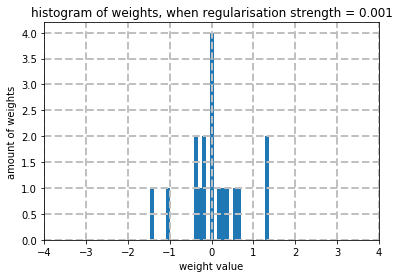

Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 1ms/step - loss: 0.5697 - val_loss: 0.1339
Epoch 2/100
900/900 [==============================] - 1s 790us/step - loss: 0.1271 - val_loss: 0.1066
Epoch 3/100
900/900 [==============================] - 1s 916us/step - loss: 0.1042 - val_loss: 0.0854
Epoch 4/100
900/900 [==============================] - 1s 930us/step - loss: 0.0874 - val_loss: 0.0716
Epoch 5/100
900/900 [==============================] - 1s 947us/step - loss: 0.0748 - val_loss: 0.0612
Epoch 6/100
900/900 [==============================] - 1s 860us/step - loss: 0.0662 - val_loss: 0.0551
Epoch 7/100
900/900 [==============================] - 1s 787us/step - loss: 0.0606 - val_loss: 0.0504
Epoch 8/100
900/900 [==============================] - 1s 834us/step - loss: 0.0561 - val_loss: 0.0468
Epoch 9/100
900/900 [==============================] - 1s 788us/step - loss: 0.0525 - val_loss: 0.0454
Epoch 10/100
900/900 [=======

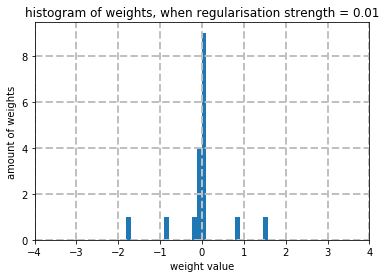

In [24]:
def weight_histogram(train_in_pure, train_out_pure, val_in_pure, val_out_pure, learning_rate):
    regu_strengths = [ 0.0001,  0.001, 0.01  ]
    num_neurons_layer1 =3
    weights_of_model = []
    
    for i in range(len(regu_strengths)):
        
        model_pure, model_history = train_2_layer_NN(train_in_pure, train_out_pure, val_in_pure, val_out_pure, learning_rate, regu_strengths[i], num_neurons_layer1)
        weights = model_pure.get_weights()
        print ('weight[1]',weights[1])
        print ('weight[3]',weights[3])
        v, w = weights[0], weights[2]
        print ("v", v)
        print ("w", w)
        
        concat_weights = np.concatenate((v.flatten(), w.flatten()))
        print ("concat_weights",concat_weights)
        weights_of_model.append (concat_weights)
        
        plt.hist(concat_weights, bins= 30 ) #bins=np.arange(-2.0, 2.0, 0.2) )
        plt.title('histogram of weights, when regularisation strength = ' + str(regu_strengths[i]))
        plt.xlim (-4 ,4 )
        plt.xlabel('weight value')
        plt.ylabel('amount of weights')
        plt.grid(color='silver', linestyle='--', linewidth=2)
        plt.savefig ('D:/Sweden/p3/ANN/lab1/part2/'+ 'histogram of weights, when regularisation strength = ' + str(regu_strengths[i]) + '.png', dpi=300)
        plt.show()
    return regu_strengths, weights_of_model
regu_strengths, weights_of_model = weight_histogram(train_in_pure, train_out_pure, val_in_pure, val_out_pure, learning_rate)

In [4]:

def train_3_layer_NN (train_input, train_output, val_input, val_output, 
                      learning_rate, regu_strength, num_neurons_layer1, num_neurons_layer2): 
    dim_InputData =5
    num_neurons_output=1
    
    model = Sequential()  
    model.add(Dense( num_neurons_layer1, 
                     input_shape=(dim_InputData,),
                     activation='sigmoid',
                     kernel_regularizer=regularizers.l1(regu_strength),  # regularizer l2 norm  defalt 0.01
                   ) )  
    model.add(Dense(num_neurons_layer2))
    model.add(Dense(num_neurons_output))

    model.compile(loss='mean_squared_error', optimizer=Adam(lr=learning_rate)  )

    es = EarlyStopping(monitor='val_loss', verbose=1)  # mode='min', 
    
    history=model.fit(train_input, train_output, 
                      validation_data=(val_input, val_output), #validation_split=0.1, 
                      nb_epoch=100, 
                      batch_size=1, 
                      verbose=1,
                      callbacks = [es]
                     )

    return model, history



 
def num_neurons_validation_3layers (how_many_iterations, train_in_noise2, train_out_noise2, val_in_noise2, val_out_noise2, test_in_noise2, test_out_noise2,
                            learning_rate, regu_strength, num_neurons_layer1, num_neurons_layer2_list):
    val_MSE_list= []
    test_MSE_list =[]
    train_MSE_list =[]
    time_3lay =[]
    
    for i in range (0, len (num_neurons_layer2_list) ):
        val= []
        test= []
        train = []
        tm= []
        
        for j in range (0, how_many_iterations): 
            start_time = time.time()
            
            model_lay3, model_history = train_3_layer_NN (train_in_noise2, train_out_noise2, val_in_noise2, val_out_noise2,  
                                                          learning_rate, 
                                                          regu_strength, 
                                                          num_neurons_layer1, 
                                                          num_neurons_layer2_list[i])
            end_time = time.time()
            time_spent= end_time - start_time
            tm.append (time_spent)
            
            val_MSE = model_history.history['val_loss'][-1]
            val.append (val_MSE)
            
            train_MSE = model_history.history['loss'][-1]
            train.append (train_MSE)  
        
            prediction = predict (model_lay3, test_in_noise2)
            test_MSE = mse (test_out_noise2, prediction) 
            test.append (test_MSE)
       
        val_MSE_list.append (mean (val))
        test_MSE_list.append (mean (test) )
        train_MSE_list.append (mean(train))
        time_3lay.append (mean (tm) )
        
    return val_MSE_list, test_MSE_list , train_MSE_list, time_3lay

learning_rate = 0.001
num_neurons_layer1 =3
num_neurons_layer2_list = [2] #[1,2,3,4,5,6,7,8]
regu_strength = 0.0001
how_many_iterations=10
valMSE_of_NumNeurons_3lay, testMSE_of_NumNeurons_3lay , trainMSE_of_NumNeurons_3lay, time_3lay =num_neurons_validation_3layers (how_many_iterations, train_in_noise2, train_out_noise2, val_in_noise2, val_out_noise2, test_in_noise2, test_out_noise2,
                                                learning_rate, regu_strength, num_neurons_layer1, num_neurons_layer2_list)



NameError: name 'train_in_noise2' is not defined

In [66]:
print (valMSE_of_NumNeurons_3lay, testMSE_of_NumNeurons_3lay , trainMSE_of_NumNeurons_3lay, time_3lay)

[0.036365765621187165] [0.0470673871177277] [0.03920791384614616] [5.55351767539978]


In [62]:
learning_rate = 0.001
num_neurons_layer1 =[3]
regu_strength = 0.0001
how_many_iterations=10
valMSE_of_NumNeurons_2lay, testMSE_of_NumNeurons_2lay, trainMSE_of_NumNeurons_2lay, time_2lay = num_neurons_validation_2lay (train_in_pure, train_out_pure, val_in_pure, val_out_pure, test_in_pure, test_out_pure,
                                                                                                         learning_rate, regu_strength, num_neurons_layer1)
print (valMSE_of_NumNeurons_2lay, testMSE_of_NumNeurons_2lay , trainMSE_of_NumNeurons_2lay, time_2lay)

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 968us/step - loss: 0.0915 - val_loss: 0.0664
Epoch 2/100
900/900 [==============================] - 1s 914us/step - loss: 0.0790 - val_loss: 0.0626
Epoch 3/100
900/900 [==============================] - 1s 872us/step - loss: 0.0770 - val_loss: 0.0606
Epoch 4/100
900/900 [==============================] - 1s 911us/step - loss: 0.0746 - val_loss: 0.0590
Epoch 5/100
900/900 [==============================] - 1s 801us/step - loss: 0.0715 - val_loss: 0.0561
Epoch 6/100
900/900 [==============================] - 1s 796us/step - loss: 0.0674 - val_loss: 0.0534
Epoch 7/100
900/900 [==============================] - 1s 846us/step - loss: 0.0628 - val_loss: 0.0490
Epoch 8/100
900/900 [==============================] - 1s 861us/step - loss: 0.0578 - val_loss: 0.0453
Epoch 9/100
900/900 [==============================] - 1s 894us/step - loss: 0.0531 - val_loss: 0.0410
Epoch 10/100
900/900 [=====

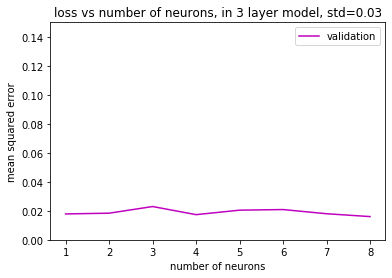

In [10]:
# how_many_iterations =1
# num_neurons_layer1 =3
# num_neurons_layer2_list =[1,2,3,4,5,6,7,8]
# valMSE_of_NumNeurons_3lay, testMSE_of_NumNeurons_3lay , trainMSE_of_NumNeurons_3lay, time_3lay =num_neurons_validation_3layers (how_many_iterations, train_in_noise1, train_out_noise1, val_in_noise1, val_out_noise1, test_in_noise1, test_out_noise1,
#                                                 learning_rate, regu_strength, num_neurons_layer1, num_neurons_layer2_list)

valMSE_of_NumNeurons_3lay_n1 = [0.017847287447657435, 0.018356732769170776, 0.02295054709247779, 0.01734496765595395, 0.02044907901319675, 0.020862036806647666, 0.017979299937724135, 0.016011479825829157]
testMSE_of_NumNeurons_3lay_n1= [0.022365567416168283, 0.033083332555628724, 0.036012061030690885, 0.02495109806603528, 0.02389649730158097, 0.027509789016764943, 0.021822756872017554, 0.026325157613222513]
trainMSE_of_NumNeurons_3lay_n1= [0.020715591868502088, 0.027068114805992485, 0.031224292000794473, 0.020263099641953077, 0.02093281160005265, 0.022609719367982405, 0.020607433409895747, 0.022199636231461126]


draw_1_line ( 'loss vs number of neurons, in 3 layer model, std=0.03','number of neurons','mean squared error', 0, 0.15,
                 num_neurons_layer2_list ,
                 valMSE_of_NumNeurons_3lay_n1,   'm', 'validation' )

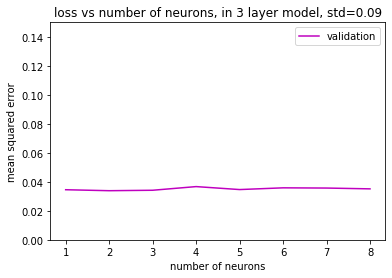

In [9]:
# how_many_iterations = 10
# num_neurons_layer1 =3
# num_neurons_layer2_list =[1,2,3,4,5,6,7,8]
# valMSE_of_NumNeurons_3lay_n2, testMSE_of_NumNeurons_3lay_n2 , trainMSE_of_NumNeurons_3lay_n2, time_3lay_n2 =num_neurons_validation_3layers (how_many_iterations, train_in_noise2, train_out_noise2, val_in_noise2, val_out_noise2, test_in_noise2, test_out_noise2,
#                                                 learning_rate, regu_strength, num_neurons_layer1, num_neurons_layer2_list)

valMSE_of_NumNeurons_3lay_n2 = [0.03454261672584107, 0.033870169902569615, 0.03417990647285478, 0.03670142721157754, 0.034656514189380684, 0.035848152986203786, 0.035695607755857055, 0.03514218092797091]
testMSE_of_NumNeurons_3lay_n2 = [0.04535761557873563, 0.04576883577070574, 0.04607828917439882, 0.04798074094432685, 0.043485370538778344, 0.04553496527505076, 0.047495227869829675, 0.044056834554279646]
trainMSE_of_NumNeurons_3lay_n2 = [0.03679711867879895, 0.03763248981369866, 0.03763248099993345, 0.03907602251879871, 0.03676817107324152, 0.0389904970271487, 0.03851811516489963, 0.036908934510856244]

# valMSE_of_NumNeurons_3lay_n2 = [0.030728079025866464, 0.03212639251782093, 0.03234045807213988, 0.036366053796955386, 0.03287043264368549, 0.03398744451405946, 0.03717249759938568, 0.032435778723447585]
draw_1_line ( 'loss vs number of neurons, in 3 layer model, std=0.09','number of neurons','mean squared error', 0, 0.15,
                 num_neurons_layer2_list ,
                 valMSE_of_NumNeurons_3lay_n2,   'm', 'validation' )



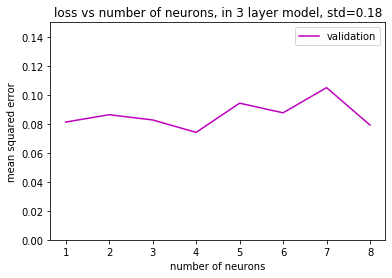

In [8]:
num_neurons_layer2_list =[1,2,3,4,5,6,7,8]
valMSE_of_NumNeurons_3lay_n3= [0.08122357489017304, 0.08628437445964664, 0.08269240111461841, 0.07410073662351352, 0.09424636822368485, 0.08759021448786371, 0.10495930640609004, 0.07914833681832534]
testMSE_of_NumNeurons_3lay_n3= [0.08344672546542689, 0.08551977580377577, 0.09376319651681246, 0.09116282003719407, 0.0872410369724474, 0.09169008981878765, 0.09803407115102196, 0.0876983728491795]
trainMSE_of_NumNeurons_3lay_n3= [0.06943313850490894, 0.06892928193523808, 0.07225046824929046, 0.07252270711100815, 0.07189261392049957, 0.07652179738681297, 0.07619784663845268, 0.07265453055804957]


draw_1_line ( 'loss vs number of neurons, in 3 layer model, std=0.18','number of neurons','mean squared error', 0, 0.15,
                 num_neurons_layer2_list ,
                 valMSE_of_NumNeurons_3lay_n3,   'm', 'validation' )

In [36]:
# best 2-layer model on pure data


learning_rate = 0.001
num_neurons_layer1 =3
regu_strength = 0.0001
how_many_iterations=3
model_pure, model_history = train_2_layer_NN(train_in_pure, train_out_pure, val_in_pure, val_out_pure, 
                                                     learning_rate, regu_strength, num_neurons_layer1)
prediction = predict (model_pure, test_in_pure)
draw_2_line ('prediction made by the best 2-layer model on pure data', 'time', 'target', 
             range( len (test_out_pure[:])), 
             test_out_pure[:], 'b', 'pure', 
             prediction,'r', 'prediction' )


c:\program files\python37\lib\site-packages\ipykernel_launcher.py:42: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 970us/step - loss: 0.1080 - val_loss: 0.0662
Epoch 2/100
900/900 [==============================] - 1s 868us/step - loss: 0.0786 - val_loss: 0.0609
Epoch 3/100
900/900 [==============================] - 1s 789us/step - loss: 0.0752 - val_loss: 0.0584
Epoch 4/100
900/900 [==============================] - 1s 798us/step - loss: 0.0704 - val_loss: 0.0550
Epoch 5/100
900/900 [==============================] - 1s 818us/step - loss: 0.0643 - val_loss: 0.0503
Epoch 6/100
900/900 [==============================] - 1s 802us/step - loss: 0.0577 - val_loss: 0.0451
Epoch 7/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0509 - val_loss: 0.0397
Epoch 8/100
900/900 [==============================] - 1s 781us/step - loss: 0.0445 - val_loss: 0.0348
Epoch 9/100
900/900 [==============================] - 1s 807us/step - loss: 0.0395 - val_loss: 0.0307
Epoch 10/100
900/900 [=======

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:24: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 900 samples, validate on 100 samples
Epoch 1/100
900/900 [==============================] - 1s 1ms/step - loss: 0.1317 - val_loss: 0.0764
Epoch 2/100
900/900 [==============================] - 1s 915us/step - loss: 0.0899 - val_loss: 0.0710
Epoch 3/100
900/900 [==============================] - 1s 912us/step - loss: 0.0889 - val_loss: 0.0702
Epoch 4/100
900/900 [==============================] - 1s 915us/step - loss: 0.0880 - val_loss: 0.0695
Epoch 5/100
900/900 [==============================] - 1s 843us/step - loss: 0.0865 - val_loss: 0.0690
Epoch 6/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0838 - val_loss: 0.0657
Epoch 7/100
900/900 [==============================] - 1s 936us/step - loss: 0.0796 - val_loss: 0.0619
Epoch 8/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0726 - val_loss: 0.0567
Epoch 9/100
900/900 [==============================] - 1s 1ms/step - loss: 0.0633 - val_loss: 0.0486
Epoch 10/100
900/900 [=============

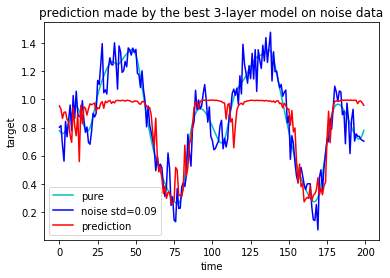

In [38]:
learning_rate = 0.001
regu_strength= 0.0001
num_neurons_layer1 =3
num_neurons_layer2 =2
model_lay3, model_history = train_3_layer_NN (train_in_noise2, train_out_noise2, val_in_noise2, val_out_noise2,  
                                              learning_rate, regu_strength, num_neurons_layer1, num_neurons_layer2)
pd = predict (model_lay3, test_in_noise2)
draw_3_line ('prediction made by the best 3-layer model on noise data', 'time', 'target', 
             range( len (test_out_pure[:])), 
             test_out_pure[:], 'c', 'pure',
             test_out_noise2[:], 'b', 'noise std=0.09', 
             pd,'r', 'prediction' )

In [15]:
def regularization_validation_3layers (how_many_iterations, train_in_noise2, train_out_noise2, val_in_noise2, val_out_noise2, test_in_noise2, test_out_noise2,
                            learning_rate, regu_strength, num_neurons_layer1, num_neurons_layer2):
    val_MSE_list= []

    for i in range (0, len (regu_strength) ):
        val= []
        test= []
        train = []
#         tm= []
        
        for j in range (0, how_many_iterations): 
#             start_time = time.time()
            
            model_lay3, model_history = train_3_layer_NN (train_in_noise2, train_out_noise2, val_in_noise2, val_out_noise2,  
                                                          learning_rate, 
                                                          regu_strength, 
                                                          num_neurons_layer1, 
                                                          num_neurons_layer2_list[i])
#             end_time = time.time()
#             time_spent= end_time - start_time
#             tm.append (time_spent)
            
            val_MSE = model_history.history['val_loss'][-1]
            val.append (val_MSE)
            
            train_MSE = model_history.history['loss'][-1]
            train.append (train_MSE)  
        
            prediction = predict (model_lay3, test_in_noise2)
            test_MSE = mse (test_out_noise2, prediction) 
            test.append (test_MSE)
                      
        val_MSE_list.append (mean (val))
        test_MSE_list.append (mean (test) )
        train_MSE_list.append (mean(train))
#         time_3lay.append (mean (tm) )
        
    return val_MSE_list

In [17]:
learning_rate = 0.001
regu_strength= [0.0001, 0.001, 0.1]
num_neurons_layer1 =3
num_neurons_layer2 =[2]
val_n2_list=[]

for j in range (0, 3):
    val_n2= regularization_validation_3layers (how_many_iterations, train_in_noise2, train_out_noise2, val_in_noise2, val_out_noise2, test_in_noise2, test_out_noise2,
                                learning_rate, regu_strength, num_neurons_layer1, num_neurons_layer2)
    val_n2_list.append (val_n2) 
print (val_n2_list)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()